# DWT and MODWT analysis of GPS station CHCM

Import the Python modules.

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from math import floor
from scipy.io import loadmat

import DWT
import MODWT
import date

%matplotlib inline

Import and clean the GPS data.

In [2]:
station = 'CHCM'
direction = 'lon'
dataset = 'cleaned'
filename = '../data/PANGA/' + dataset + '/' + station + '.' + direction

In [3]:
data = np.loadtxt(filename, skiprows=26)
time = data[:, 0]
disp = data[:, 1]

In [4]:
dt = np.diff(time)
gap = np.where(dt < 1.0 / 365.0 - 0.001)[0]
print(gap)

[2231]


In [5]:
print(time[gap[0] - 2 : gap[0] + 4])
print(dt[gap[0] - 2 : gap[0] + 4])

[2011.73717 2011.7399  2011.74264 2011.74264 2011.74538 2011.75086]
[0.00273 0.00274 0.      0.00274 0.00548 0.00273]


In [6]:
time[gap[0] + 1] = time[gap[0] + 2]
time[gap[0] + 2] = 0.5 * (time[gap[0] + 2] + time[gap[0] + 3])
print(time[gap[0] - 2 : gap[0] + 4])

[2011.73717 2011.7399  2011.74264 2011.74538 2011.74812 2011.75086]


In [7]:
days = 2
dt = np.diff(time)
gap = np.where(dt > days / 365.0 + 0.001)[0]
print(time[gap])
print(gap)

[2004.6078  2004.91444 2005.18001 2005.2731  2005.34702 2005.42916
 2005.49487 2005.60438 2005.61533 2005.79877 2005.83984 2005.86174
 2006.30253 2006.63655 2007.04449 2007.18412 2007.27995 2007.29637
 2007.32375 2007.46064 2007.49076 2007.86311 2007.88501 2008.06845
 2009.03765 2009.30322 2009.57974 2010.07803 2010.99795 2011.1321
 2011.40041 2013.02943 2015.82752 2016.93634 2017.4319  2017.78782
 2017.80698 2017.81793 2018.03696]
[   0    2   69   87  112  140  160  194  196  234  246  250  407  524
  663  712  744  747  750  795  804  937  938  991 1337 1378 1474 1652
 1969 2015 2110 2701 3717 4109 4276 4398 4403 4405 4478]


In [8]:
ibegin = 1652
iend = 1969
time_sub = time[ibegin + 1 : iend + 1]
disp_sub = disp[ibegin + 1 : iend + 1]
print(time_sub[0])
print(time_sub[-1])

2010.13279
2010.99795


In [9]:
dt = np.diff(time_sub)
gap = np.where(dt > 1.0 / 365.0 + 0.001)[0]
print(gap)

[]


In [10]:
for i in range(0, len(gap)):
    time_sub = np.insert(time_sub, gap[i] + 1, time_sub[gap[i]] + 1.0 / 365.0)
    disp_sub = np.insert(disp_sub, gap[i] + 1, 0.5 * (disp_sub[gap[i]] + disp_sub[gap[i] + 1]))
    gap[i : ] = gap[i : ] + 1
print(gap)
print(len(time_sub))

[]
317


Choose the level of MODWT analysis.

In [11]:
J = 6
time = time_sub
disp = disp_sub

Load the tremor data from the catalog of the Arrays of Arrays experiment, and set the time of the ETS and inter-ETS events.

In [12]:
data = loadmat('../data/timelags/mbbp_cat_d_forHeidi')
mbbp_cat_d = data['mbbp_cat_d']
time_tremor = mbbp_cat_d[:, 0] / 365.25
lat_tremor = mbbp_cat_d[:, 2]
lon_tremor = mbbp_cat_d[:, 3]
time_ETS = [2009.823, 2010.172, 2010.465, 2010.59]

Compute and plot the MODWT coefficients.

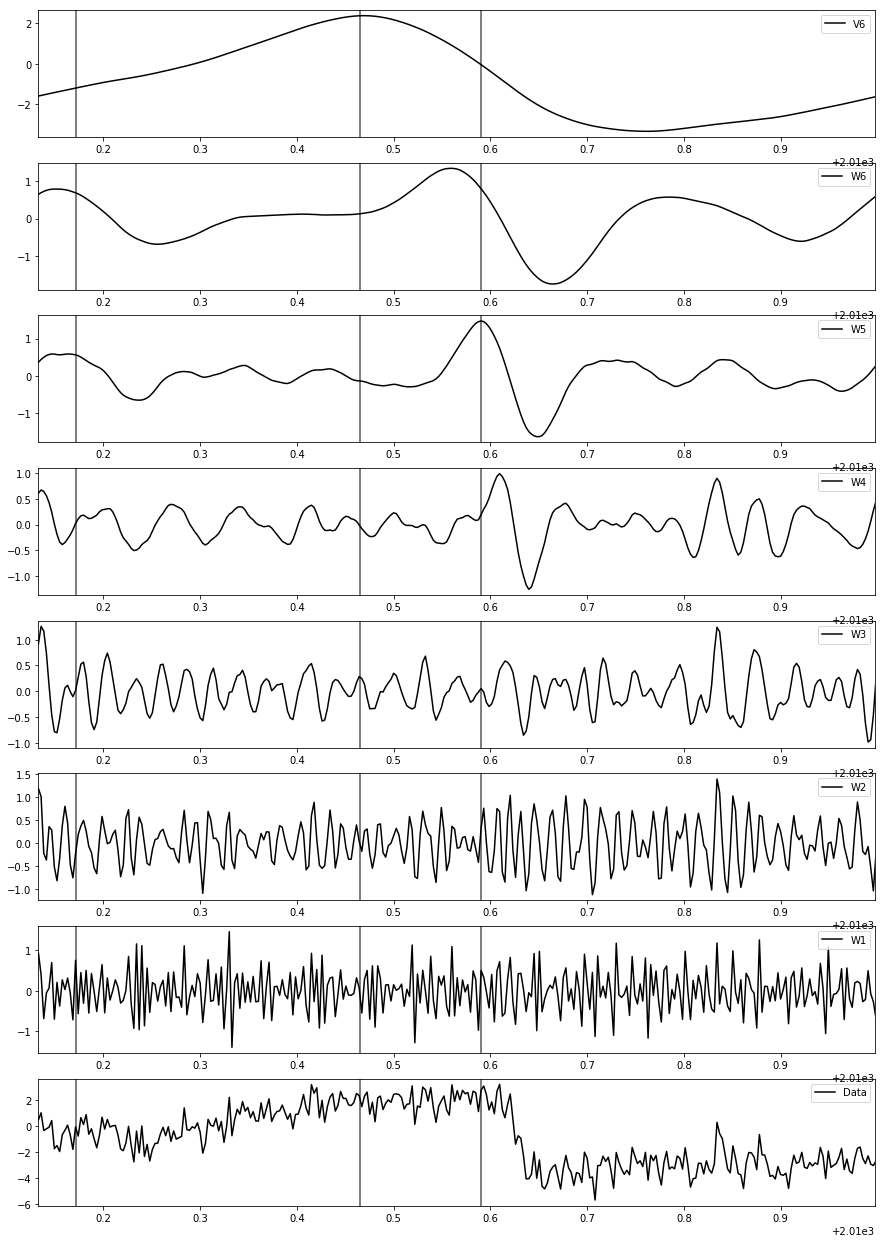

In [13]:
# Compute MODWT
[W, V] = MODWT.pyramid(disp, 'LA8', J)
(nuH, nuG) = DWT.get_nu('LA8', J)

N = np.shape(disp)[0]
t0 = time[0]
dt = 1.0 / 365.0
plt.figure(1, figsize=(15, 22))

# Plot data
plt.subplot2grid((J + 2, 1), (J + 1, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(t0 + dt * np.arange(0, N), disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot wavelet coefficients at each level
for j in range(1, J + 1):
    Wj = W[j - 1]
    plt.subplot2grid((J + 2, 1), (J + 1 - j, 0))
    for i in range(0, len(time_ETS)):
        plt.axvline(time_ETS[i], linewidth=2, color='grey')
    for i in range(0, len(gap)):
        plt.axvline(time[gap[i]], linewidth=1, color='red')
    plt.plot(t0 + dt * np.arange(0, N), np.roll(Wj, nuH[j - 1]), 'k', label = 'W' + str(j))
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

# Plot scaling coefficients for the last level
plt.subplot2grid((J + 2, 1), (0, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(t0 + dt * np.arange(0, N), np.roll(V, nuG[J - 1]), 'k', label = 'V' + str(J))
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

plt.show()

Compute and plot the MODWT details and smooth.

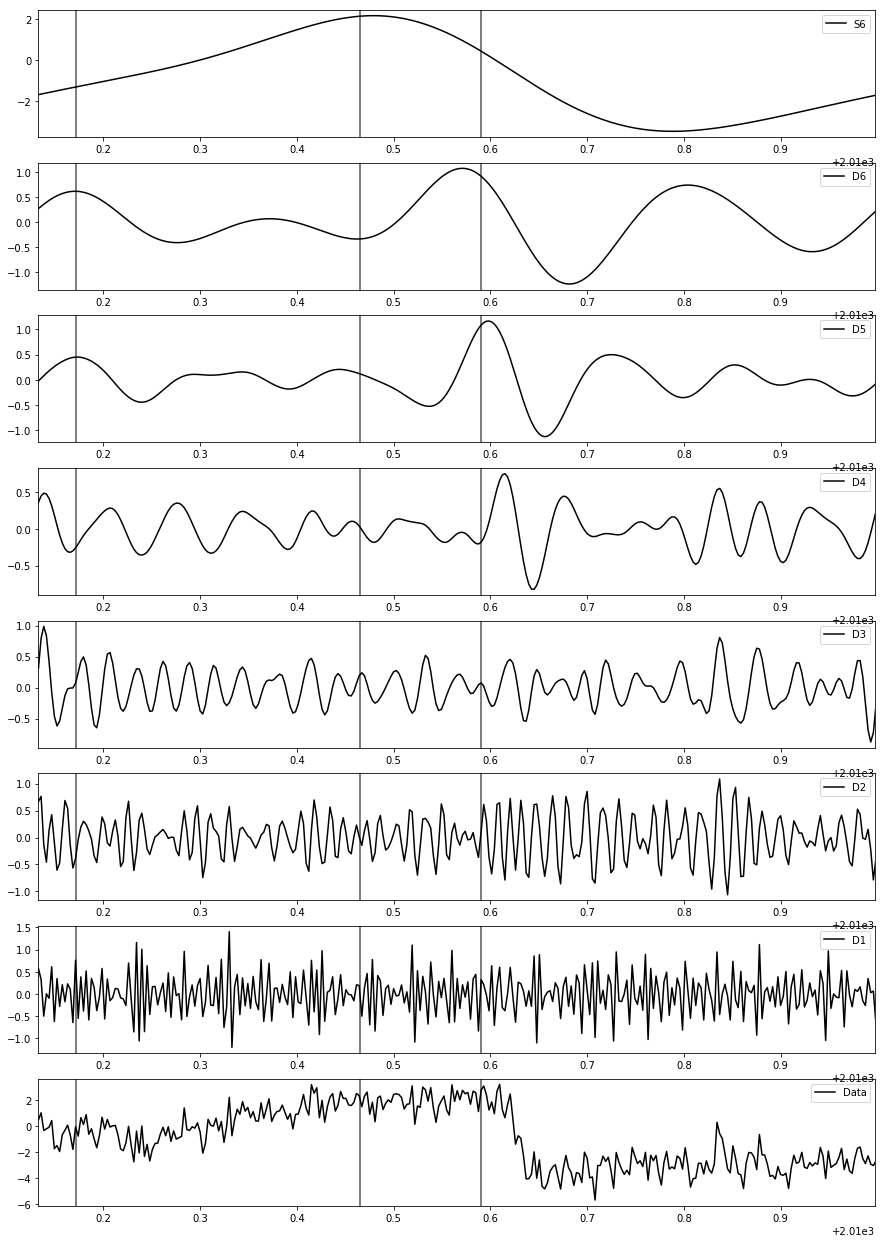

In [14]:
(D, S) = MODWT.get_DS(disp, W, 'LA8', J)

plt.figure(1, figsize=(15, 22))

# Plot data
plt.subplot2grid((J + 2, 1), (J + 1, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(t0 + dt * np.arange(0, N), disp, 'k', label='Data')
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

# Plot details at each level
for j in range(0, J):
    plt.subplot2grid((J + 2, 1), (J - j, 0))
    for i in range(0, len(time_ETS)):
        plt.axvline(time_ETS[i], linewidth=2, color='grey')
    for i in range(0, len(gap)):
        plt.axvline(time[gap[i]], linewidth=1, color='red')
    plt.plot(t0 + dt * np.arange(0, N), D[j], 'k', label='D' + str(j + 1))
    plt.xlim(np.min(time), np.max(time))
    plt.legend(loc=1)

# Plot smooth for the last level
plt.subplot2grid((J + 2, 1), (0, 0))
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(t0 + dt * np.arange(0, N), S[J], 'k', label='S' + str(J))
plt.xlim(np.min(time), np.max(time))
plt.legend(loc=1)

plt.show()

Plot the 5th and 6th level details along with the cumulative number of tremor.

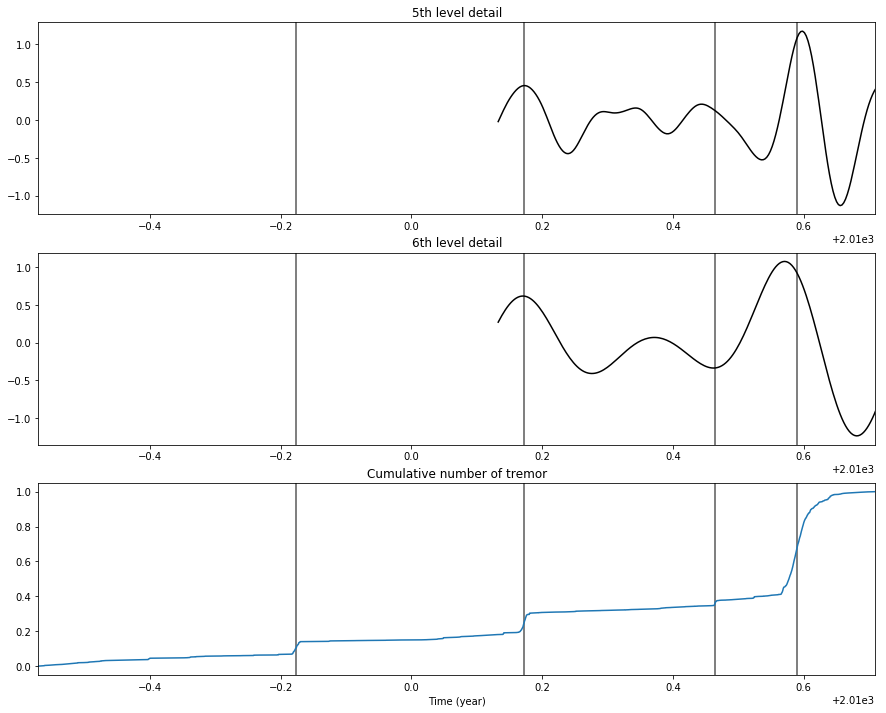

In [15]:
plt.figure(1, figsize=(15, 12))

# Plot 5th detail of DWT analysis
plt.subplot(311)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(t0 + dt * np.arange(0, N), D[4], 'k', label='Data')
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.title('5th level detail')

# Plot 6th detail of DWT analysis
plt.subplot(312)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
for i in range(0, len(gap)):
    plt.axvline(time[gap[i]], linewidth=1, color='red')
plt.plot(t0 + dt * np.arange(0, N), D[5], 'k', label='Data')
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.title('6th level detail')

# Plot cumulative number of tremor
plt.subplot(313)
for i in range(0, len(time_ETS)):
    plt.axvline(time_ETS[i], linewidth=2, color='grey')
nt = np.shape(time_tremor)[0]
plt.plot(np.sort(time_tremor), (1.0 / nt) * np.arange(0, len(time_tremor)))
plt.xlim(np.min(time_tremor), np.max(time_tremor))
plt.xlabel('Time (year)')
plt.title('Cumulative number of tremor')

plt.show()